# Final Project Machine Learning Course

> Spotify dataset classification

<img alt="spotify-logo" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Spotify_logo_without_text.svg/2048px-Spotify_logo_without_text.svg.png" width="30" height="30">

### <i>Dataset <a href="https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv">link</a></i>


# Goal
The goal of this project is to train machine learning models (supervised) that will classified the popularity of a spotify song to three classes:
1. high popular
2. medium popular
3. non popular

In [1]:
# data science models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# others
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# utils
from utils import get_date_times, apply_popularity, get_years

# learning models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [2]:
# read data
tracks = pd.read_csv("data/tracks.csv")
print(f"shape of tracks data set is: {tracks.shape[0]} rows × {tracks.shape[1]} columns")

shape of tracks data set is: 586672 rows × 20 columns


## Plot functions

In [3]:
def print_pie(values, lables):
    """
    Function that get values and labels and ploting a pie
    """
    values = list(values)
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    ax.pie(values, labels=lables, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')
    plt.show()

In [4]:
def my_plot_confusion_matrix(clf, X_test, y_test):
    """
    Function that ploting confusion_matrix
    """
    # get the confusion_matrix for ploting
    matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)

    # main title
    matrix.ax_.set_title('Confusion matrix')

    # x label
    plt.xlabel('Predicted Label')

    # y label
    plt.ylabel('True label')

    # size of the figure
    plt.gcf().set_size_inches(10, 6)

    # show plot
    plt.show()

In [5]:
# def print_accuracy(clf, X_train, X_test, y_train, y_test):
#     """
#     Function that print the accuracy of a model
#     """
#     # fit the train data to the model
#     clf.fit(X_train, y_train)

#     # get the pridictions of X_test
#     pridictions = clf.predict(X_test)

#     # get the accuracy of the model
#     accuracy = clf.score(X_test, y_test)

#     # print the accuracy
#     print('accuracy of the model is: {} %'.format("%.2f" % (accuracy * 100)))

# function that print the accuracy of a classification model
def print_accuracy(clf, X_train, X_test, y_train, y_test):
    # fit the train data to the model
    clf.fit(X_train, y_train)

    # get the pridictions of X_test
    pridictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    probabilities = probabilities[:, 1]

    # get the accuracy of the model
    accuracy = clf.score(X_test, y_test)

    # print the accuracy
    print(classification_report(y_test, pridictions))
    print('accuracy of the model is: {} %'.format("%.2f" % (accuracy * 100)))
    return accuracy

# Understanding the data:

### Data features:

1. acousticness (Ranges from 0 to 1)
2. artists (List of artists mentioned)
3. danceability (Ranges from 0 to 1)
4. duration_ms (Integer typically ranging from 200k to 300k)
5. energy (Ranges from 0 to 1)
6. explicit (0 = No explicit content, 1 = Explicit content) ## Categorical:
7. id (Id of track generated by Spotify) ## Numerical:
8. id_artists
9. instrumentalness (Ranges from 0 to 1)
10. key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
11. liveness (Ranges from 0 to 1)
12. loudness (Float typically ranging from -60 to 0)
13. mode (0 = Minor, 1 = Major)
14. name (Name of the song)
15. popularity (Ranges from 0 to 100)
16. release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
17. speechiness (Ranges from 0 to 1)
18. tempo (Float typically ranging from 50 to 150)
19. time_signature
20. valence (Ranges from 0 to 1)

In [6]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [7]:
tracks.tail()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.615,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4
586671,5Ocn6dZ3BJFPWh4ylwFXtn,Mar de Emociones,38,214360,0,['Afrosound'],['0i4Qda0k4nf7jnNHmSNpYv'],2015-07-01,0.686,0.723,6,-7.067,1,0.0363,0.105,0.000000,0.2640,0.9750,112.204,4


In [8]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [9]:
# another check for finding null objects
tracks.isnull().sum()

# as we can see there is null objects at name feature but we drop this feature anyway in data cleaning

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

In [10]:
date_times = get_date_times(tracks['release_date'])
print(f"Minimum release date is: {min(date_times).strftime('%Y-%m-%d')}")
print(f"Maximum release date is: {max(date_times).strftime('%Y-%m-%d')}")

Minimum release date is: 1900-01-01
Maximum release date is: 2021-04-16


In [11]:
tracks['popularity'].describe()

count    586672.000000
mean         27.570053
std          18.370642
min           0.000000
25%          13.000000
50%          27.000000
75%          41.000000
max         100.000000
Name: popularity, dtype: float64

### Show the 10 most popular tracks:

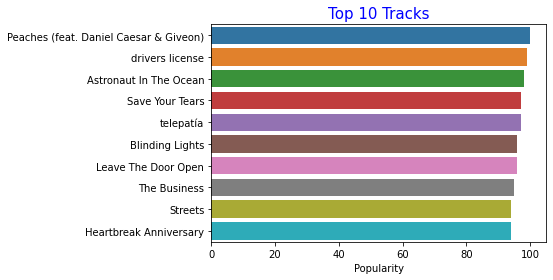

In [12]:
most_popular_tracks = tracks.nlargest(10, 'popularity')
fig, ax = plt.subplots()
ax = sns.barplot(x=most_popular_tracks['popularity'].values, y=most_popular_tracks['name'].values)
ax.set_xlabel("Popularity")
ax.set_title("Top 10 Tracks", c='b', fontsize=15)
plt.show()

### Show the 10 most popular artists:

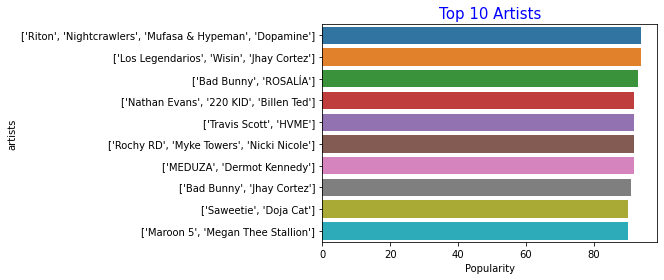

In [13]:
most_popular_artists = tracks.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(10)
fig, ax = plt.subplots()
ax = sns.barplot(x=most_popular_artists.values, y=most_popular_artists.index)
ax.set_xlabel("Popularity")
ax.set_title("Top 10 Artists", c='b', fontsize=15)
plt.show()

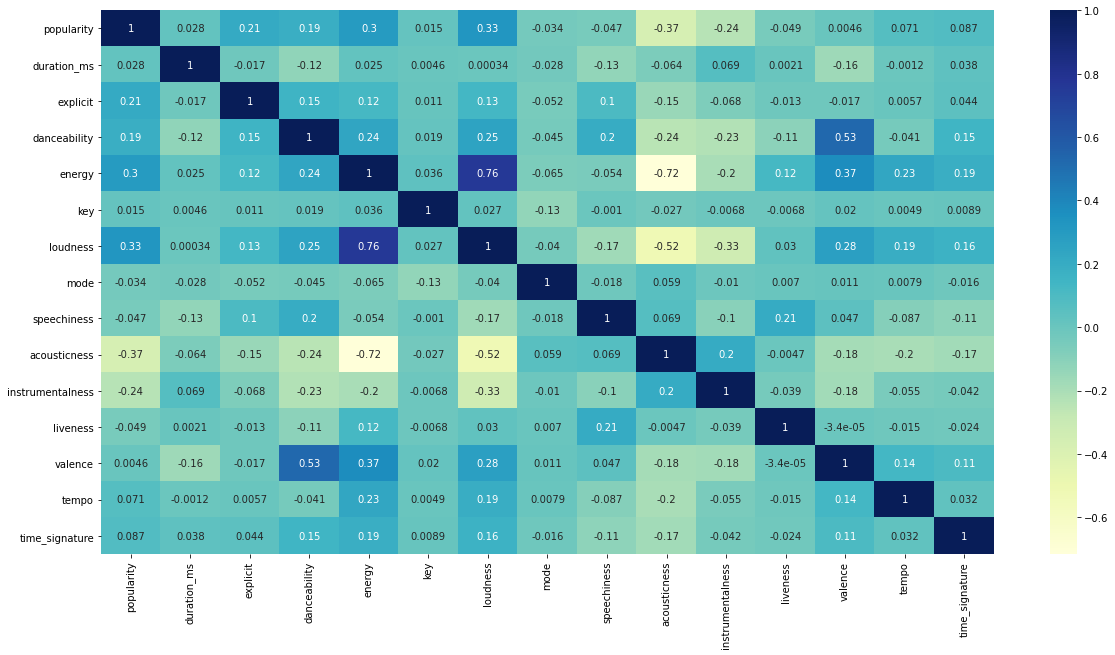

In [14]:
plt.figure(figsize=(20, 10))
sns.heatmap(tracks.corr(), annot=True, cmap="YlGnBu")
plt.show()

### Create feature with the year of the release date of the track

In [15]:
tracks['year'] = get_years(tracks['release_date'])

### Show ratio of each numerical value with popularity

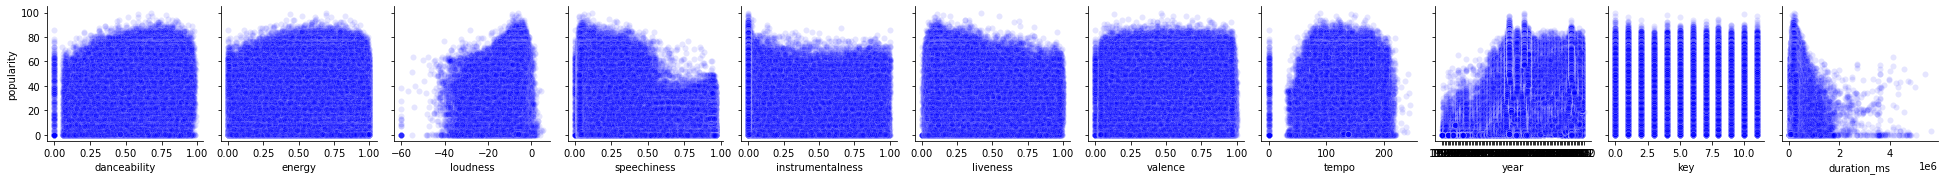

In [16]:
pp = sns.pairplot(data=tracks,
                  y_vars=['popularity'],
                  x_vars=['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness',
                   'valence', 'tempo', 'year', 'key', 'duration_ms'],
                  kind='scatter', plot_kws={'color': 'b', 'alpha': 0.1}, palette='r')

<AxesSubplot:title={'center':'Growth of popularity by years'}, xlabel='year'>

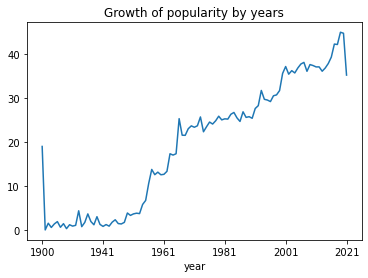

In [17]:
tracks.groupby('year')['popularity'].mean().plot(title="Growth of popularity by years")

<AxesSubplot:title={'center':"Growth of popularity of 'The Beatles' by years"}, xlabel='year'>

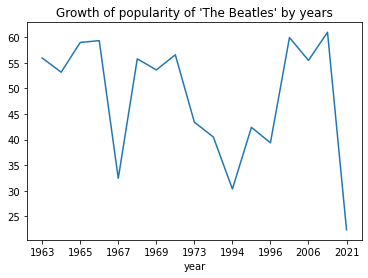

In [18]:
beatles = tracks[tracks['artists'] == "['The Beatles']"]
beatles.groupby('year')['popularity'].mean().plot(title="Growth of popularity of 'The Beatles' by years")

## Clearing the data

### Remove tracks with 0 popularity

In [19]:
# as we can see there is 44690 tracks with 0 popularity, we want to delete theme to make our data more balanced
tracks['popularity'].value_counts().sort_index()

0      44690
1      12024
2       9639
3       8154
4       7733
       ...  
96         2
97         2
98         1
99         1
100        1
Name: popularity, Length: 101, dtype: int64

In [20]:
# remove all the tracks with popularity of 0
tracks = tracks[tracks.popularity != 0]

### Remove duplicate tracks, keep only the one with the max popularity

In [21]:
# remove each row that the name of the artiest + the name of the track is the same - save the maximum value of popularity
tracks['artists+name'] = tracks.apply(lambda row: str(row['artists']) + str(row['name']), axis=1)
num_of_rows_before_remove_duplicates = tracks.shape[0]
tracks = tracks[tracks['popularity'] == tracks.groupby('artists+name')['popularity'].transform('max')]
print(f"removed {num_of_rows_before_remove_duplicates - tracks.shape[0]} duplicates tracks")

removed 53347 duplicates tracks


### Make popularity to be classification values

In [22]:
# apply popularity for classification in the following format:
# 
# if <= 70 popularity             - high popular      value: 2
# else if 40 <= popularity < 70   - medium popular    value: 1
# else, popularity < 40           - non popular       value: 0

tracks['popularity'] = tracks['popularity'].apply(lambda x: apply_popularity(x))

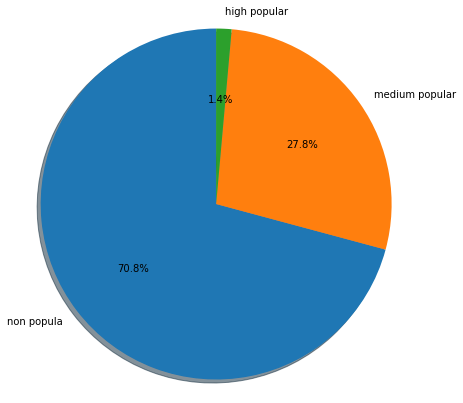

In [23]:
# plot the relative between popularities
values = tracks['popularity'].value_counts()
labels = ['non popula', 'medium popular', 'high popular']
print_pie(values, labels)

### Drop unnecessary features

In [24]:
# drop id & name of the song
tracks=tracks.drop(columns=['id','name','artists', 'id_artists', 'release_date', 'artists+name'])

In [25]:
tracks.head(10)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,0,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,1922
13,0,186800,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,1922
26,0,180800,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,1922
149,1,177133,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,1923
150,0,161933,0,0.831,0.2620,8,-12.386,1,0.0942,0.984,0.912000,0.204,0.901,104.606,4,1923
151,0,206600,0,0.537,0.0443,3,-16.474,0,0.0343,0.996,0.000265,0.152,0.137,80.468,4,1923
152,0,192600,0,0.665,0.2540,8,-9.879,1,0.1080,0.976,0.002170,0.644,0.503,125.734,4,1923
153,0,181173,0,0.709,0.0620,5,-12.207,1,0.0480,0.995,0.003410,0.120,0.553,85.854,4,1923
154,0,167640,0,0.693,0.0270,0,-13.506,0,0.0562,0.992,0.000000,0.134,0.402,75.749,4,1923
155,0,201480,0,0.771,0.0905,3,-7.788,1,0.0613,0.986,0.000141,0.152,0.601,87.571,4,1923


# Classification Models

In [26]:
feature_cols = ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'time_signature', 'year']
X = tracks[feature_cols]
y = tracks['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

### Using KNeighborsClassifier model

In [27]:
# get the classifier (found that 5 neighbors is the best predicter)
nclf = KNeighborsClassifier(n_neighbors=5)

# print accuracy
print_accuracy(nclf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     86291
           1       0.50      0.36      0.42     34110
           2       0.03      0.00      0.00      1758

    accuracy                           0.71    122159
   macro avg       0.43      0.41      0.41    122159
weighted avg       0.68      0.71      0.69    122159

accuracy of the model is: 71.41 %


0.7141266709779877

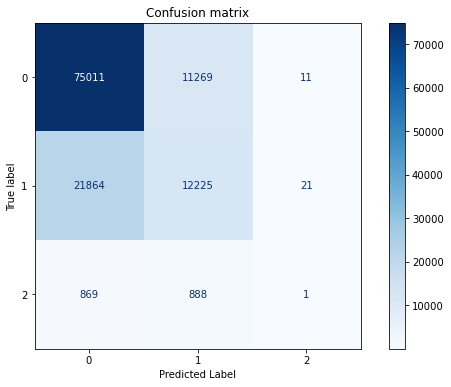

In [28]:
my_plot_confusion_matrix(nclf, X_test, y_test)

### Using LogisticRegression classifier model

In [29]:
# get the classifier 
lclf = LogisticRegression()

# print accuracy
print_accuracy(lclf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     86291
           1       0.20      0.00      0.00     34110
           2       0.00      0.00      0.00      1758

    accuracy                           0.71    122159
   macro avg       0.30      0.33      0.28    122159
weighted avg       0.55      0.71      0.58    122159

accuracy of the model is: 70.63 %


0.7062598744259531

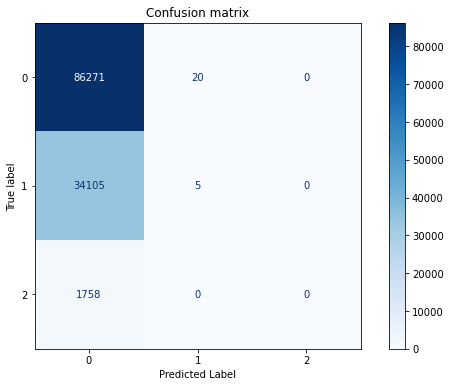

In [30]:
my_plot_confusion_matrix(lclf, X_test, y_test)

### Using Extreme Gradient Boosting:

In [31]:
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    n_jobs=-1)

# print accuracy
print_accuracy(xgb_model, X_train, X_test, y_train, y_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.year

In [ ]:
my_plot_confusion_matrix(xgb_model, X_test, y_test)

In [ ]:
# crate mlp
classifier_mlp = MLPClassifier(
    activation='relu', learning_rate_init=0.1,
    hidden_layer_sizes=(3,), random_state=1, max_iter=200)

# train mlp with train set
classifier_mlp.fit(X_train, X_test)